In [1]:
from copy import deepcopy
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

from naf import NNet as NAF
from ddpg import Actor, Critic
from naf.priority_buffer import PriorityBuffer

Using Theano backend.


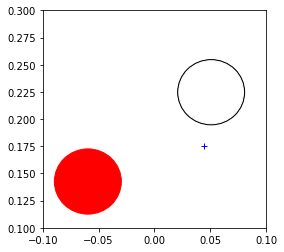

In [14]:
import numpy as np


def random(a, b):
    return a + (b - a) * np.random.rand()


class Circle:
    
    def __init__(self, pos):
        self.radius = 0.03
        self.pos = pos
        
    def interact(self, eef):
        d = self.pos - eef
        theta = np.arctan2(d[1], d[0])
        center_distance = np.linalg.norm(d)
        distance = self.radius - center_distance
        if center_distance > self.radius:
            return
        self.pos += np.array([
            distance * np.cos(theta),
            distance * np.sin(theta)
        ])


class Environment:
    
    def __init__(self):
        self.max_dist = 0.01
        self.min_x = -0.10
        self.max_x = 0.10
        self.min_y = 0.10
        self.max_y = 0.30
        self.LOSE = 0
        self.NEUTRAL = 1
        self.WIN = 2
        self.reset()
        
    def reset(self):
        circle_pos = np.array([
            random(self.min_x + 0.04, self.max_x - 0.04),
            random(self.min_y + 0.04, self.max_y - 0.04)]
        )
        self.goal = np.array([
            random(self.min_x + 0.04, self.max_x - 0.04),
            random(self.min_y + 0.04, self.max_y - 0.04)]
        )
        while True:
            self.eef = np.array([
                random(self.min_x, self.max_x),
                random(self.min_y, self.max_y)]
            )
            if np.linalg.norm(self.eef - circle_pos) > 0.03:
                break
        self.circle = Circle(circle_pos)

    @property
    def x_size(self):
        relative_to_circle = 2
        circle_to_goal_distance = 1
        return relative_to_circle + circle_to_goal_distance
    
    @property
    def u_size(self):
        return 2
        
    def get_state(self):
        # Calculate rotation of circle relative to goal
        d = self.circle.pos - self.goal
        d_norm = np.linalg.norm(d)
        noise = np.random.randn(3) * np.array([0.005, 0.005, 0.005]) * 0.0
        if d_norm > 0:
            alpha = np.arctan2(d[1], d[0])
            rot = np.array([[np.cos(alpha), np.sin(alpha)], [-np.sin(alpha), np.cos(alpha)]])
            rel = np.dot(rot, self.eef - self.circle.pos)
            return np.array([
                rel[0], # eef_x
                rel[1],    # eef_y
                d_norm  # circle to goal distance
            ]) + noise
        else:
            # If circle is at goal, let eef be on x-axis
            return np.array([
                np.linalg.norm(self.eef - self.circle.pos), # eef_x
                0.0, # eef_y
                0.0  # circle to goal distance
            ]) + noise
    
    def step(self, u):
        u = u + np.random.randn(*u.shape) * 0.002 * 0.0
        d = self.circle.pos - self.goal
        d_norm_before = np.linalg.norm(d)
        if d_norm_before > 0:
            alpha = np.arctan2(d[1], d[0])
            rot = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
            rel = np.dot(rot, u)
            self.eef += rel
            self.circle.interact(self.eef)
        else:
            g2e = self.eef - self.goal
            alpha = np.arctan2(g2e[1], g2e[0])
            rot = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
            u_rot = np.dot(rot, u)
            self.eef += u_rot
        self.circle.interact(self.eef)
        d_after = self.circle.pos - self.goal
        d_norm_after = np.linalg.norm(d_after)
        eef2circle = np.linalg.norm(self.eef - self.circle.pos)
        reward = (
            1000 * (d_norm_before - d_norm_after) +
            np.exp(-1000 * d_norm_after) +
            0.1 * np.exp(-200 * eef2circle)
        )
        
        ## Rewards for noisy task
        #reward_cube = 20 * np.exp(-100 * eef2circle)
        #reward_goal = 20 * np.exp(-100 * d_norm_after)
        #reward = 1.0 * reward_cube + 1.0 * reward_goal
        
        state = self.NEUTRAL
        if d_norm_after > 0.30:
            state = self.LOSE
        return self.get_state(), reward, state == self.LOSE, state
        
    def plot(self, ax=None, eef_color='b', circle_alpha=1.0):
        import matplotlib.pyplot as plt
        if ax is None:
            fig, ax = plt.subplots(figsize=(4, 4))
        ax.add_artist(plt.Circle(
            self.goal,
            self.circle.radius,
            color='k',
        ))
        ax.add_artist(plt.Circle(
            self.goal,
            self.circle.radius - 0.001,
            color='w',
        ))
        ax.add_artist(plt.Circle(
            deepcopy(self.circle.pos),
            self.circle.radius,
            alpha=circle_alpha,
            color='r',
        ))
        ax.plot(*self.eef, '+', color=eef_color)
        ax.set_xlim((self.min_x, self.max_x))
        ax.set_ylim((self.min_y, self.max_y))

env_ddpg = Environment()
env_ddpg.plot()
plt.savefig('../master-thesis/res/env_sim1.pdf')
plt.show()

In [3]:
critic = Critic(env_ddpg.x_size, env_ddpg.u_size)
critic_target = Critic(env_ddpg.x_size, env_ddpg.u_size)
actor = Actor(env_ddpg.x_size, env_ddpg.u_size, critic)
actor_target = Actor(env_ddpg.x_size, env_ddpg.u_size, critic)
critic_target.q.set_weights(critic.q.get_weights())
actor_target.u.set_weights(actor.u.get_weights())

In [4]:
actor_target.load_params('./ddpg/ddpg-actor-params.txt')
critic_target.load_params('./ddpg/ddpg-critic-params.txt')

In [ ]:
def sample_batch(buffer, env, size=32):
    x_size = env.x_size
    X = np.zeros((size, x_size))
    Xp = np.zeros((size, x_size))
    U = np.zeros((size, 2))
    R = np.zeros((size, 1))
    S = np.zeros((size, 1))
    exp_nodes = []
    for i in range(size):
        sample = buffer.sample()
        exp_nodes.append(sample)
        X[i, :] = sample.data['x']
        Xp[i, :] = sample.data['xp']
        U[i, :] = sample.data['u']
        R[i, :] = sample.data['r']
        S[i, :] = sample.data['s']
    return X, U, Xp, R, S, exp_nodes

In [ ]:
def plot_v(actor_f, critic_f, env):
    env = deepcopy(env)
    x_size = env.get_state().shape[0]
    res = 64
    xs = np.linspace(env.min_x, env.max_x, res)
    ys = np.linspace(env.min_y, env.max_y, res)
    xss, yss = np.meshgrid(xs, ys)
    zss = np.zeros(xss.shape)
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            env.eef = np.array([x, y])
            X = env.get_state().reshape(1, env.x_size)
            zss[len(ys) - j - 1, i] = critic_f([X, actor_f(X)])
    plt.imshow(zss, cmap='inferno', interpolation='gaussian', aspect='auto',
               extent=[env.min_x, env.max_x, env.min_y, env.max_y])
    plt.plot(*env.goal, 'wo', alpha=0.4, markersize=80, fillstyle='none')
    plt.plot(*env.circle.pos, 'ro', alpha=0.2, markersize=80)

    plt.xticks(np.linspace(env.min_x, env.max_x, 5))
    plt.yticks(np.linspace(env.min_y, env.max_y, 5))
    plt.title('$V(\mathbf{x})$')
    plt.colorbar().set_label('$V(\mathbf{x})$')
    
env_ddpg.reset()
env_ddpg.circle.pos = np.array([-0.03, 0.20])
env_ddpg.goal = np.array([0.03, 0.20])
plot_v(actor_target.u.predict, critic_target.q.predict, env_ddpg)
#plot_v(naf.mu.predict, naf.q.predict, env_naf)
plt.show()

In [ ]:
def plot_pi(u_func, env, eef=None):
    from copy import deepcopy
    env = deepcopy(env)
    res = 25
    for x in np.linspace(env.min_x, env.max_x, res):
        for y in np.linspace(env.min_y, env.max_y, res):
            env.eef = np.array([x, y])
            u = u_func(env.get_state().reshape(1, env.x_size))[0, :]
            d = env.circle.pos - env.goal
            d_norm = np.linalg.norm(d)
            if d_norm > 0:
                alpha = np.arctan2(d[1], d[0])
                rot = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
                rel = np.dot(rot, u)
            dx, dy = rel
            plt.arrow(x, y, 0.01 * dx, 0.01 * dy, head_width=0.002)
    plt.plot(*env.goal, 'ko', alpha=1.0, markersize=80, fillstyle='none')
    plt.plot(*env.circle.pos, 'ro', alpha=0.4, markersize=80)
    
    plt.title('$\mathbf{\pi(x)}$')
    plt.xlim(env.min_x, env.max_x)
    plt.ylim(env.min_y, env.max_y)
    
env_ddpg.reset()
env_ddpg.circle.pos = np.array([-0.03, 0.20])
env_ddpg.goal = np.array([0.03, 0.20])
plot_pi(actor_target.u.predict, env_ddpg)
plt.show()

In [ ]:
priority_buffer_ddpg = PriorityBuffer(2 ** 17)

In [ ]:
def evaluate(actor_predict_func, env):
    n_trials = 16
    R = 0.0
    for n in range(n_trials):
        np.random.seed(n)
        env.reset()
        for i in range(512):
            x = env.get_state().reshape(1, env.x_size)
            _, r, _, _ = env.step(env.max_dist * actor_predict_func(x).flatten())
            R += 0.99 ** i * r
    np.random.seed(datetime.now().microsecond)
    return R / n_trials

In [ ]:
i = 0
params = []
last_reset_ddpg = i
batch_size = 64
ddpg_evals = []
naf_evals = []
env_ddpg.reset()
n_iterations = 100000
for i in range(i, n_iterations):
    x = env_ddpg.get_state().reshape(1, env_ddpg.x_size)
    epsilon = max(0.1, 1 - 1e-6 * i)
    u = (1 - epsilon) * actor.u.predict(x) + epsilon * 2 * (np.random.rand(1, 2) - 0.5)
    xp, r, done, state = env_ddpg.step(u.flatten() * env_ddpg.max_dist)
    # DDPG
    priority_buffer_ddpg.add({
        'x': x,
        'u': u.flatten(),
        'r': r,
        'xp': xp.flatten(),
        's': state
    }).set_value(10.0)
    X, U, Xp, R, S, exp_nodes = sample_batch(priority_buffer_ddpg, env_ddpg, size=batch_size)
    target_q = R + 0.99 * critic_target.q.predict([Xp, actor_target.u.predict(Xp)])
    q = critic.q.predict([X, U])
    beta_isac = 1.0 * (n_iterations - i) / n_iterations
    [n.set_value(e) for n, e in zip(exp_nodes, beta_isac * abs(target_q - q).flatten() + 1e-9)]
    critic.q.fit([X, U], target_q, batch_size=batch_size, nb_epoch=1, verbose=False)
    actor.q.fit(X, np.zeros(target_q.shape), batch_size=batch_size, nb_epoch=1, verbose=False)
    actor_target.soft_update(actor)
    critic_target.soft_update(critic)
    if done or i - last_reset_ddpg > 64:
        last_reset_ddpg = i
        env_ddpg.reset()
    
    if i % 1000 == 0:
        print('epsilon:', epsilon)
        print('iteration:', i)
        params.append((
            actor_target.q.get_weights(),
            critic_target.q.get_weights()
        ))
        #naf_evals.append(evaluate(naf.mu.predict, env_naf))
        ddpg_evals.append(evaluate(actor_target.u.predict, env_ddpg))
        #naf_handle, = plt.plot(naf_evals, 'g', label='NAF')
        ddpg_handle, = plt.plot(ddpg_evals, 'b', label='DDPG')
        plt.show()
        #env_naf.reset()
        #print('naf')
        #plt.figure(figsize=(10, 4))
        #plt.subplot(121)
        #plot_pi(naf.mu.predict, env_naf)
        #plt.subplot(122)
        #plot_v(naf.mu.predict, naf.q.predict, env_naf)
        #plt.show()
        env_ddpg.reset()
        print('ddpg')
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plot_pi(actor_target.u.predict, env_ddpg)
        plt.subplot(122)
        plot_v(actor_target.u.predict, critic_target.q.predict, env_ddpg)
        plt.show()

In [ ]:
#ddpg_evals1 = ddpg_evals
#ddpg_evals2 = ddpg_evals
#params2 = params
#ddpg_evals3 = ddpg_evals
#params3 = params

In [ ]:
plt.plot(ddpg_evals1)
plt.plot(ddpg_evals2)
plt.plot(ddpg_evals3)
plt.ylabel('$\mathbb{E}(R_1)$')
plt.xlabel('Update step')
#plt.savefig('ddpg-pushing-sim-several-runs.pdf')
plt.show()

In [ ]:
ind = np.argmax(ddpg_evals2)
best_params = params2[ind]

In [ ]:
import pickle
with open('ddpg-best-params.pkl', 'wb') as f:
    pickle.dump(best_params, f)

In [ ]:
actor_target.q.set_weights(best_params[0])
critic_target.q.set_weights(best_params[1])

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_pi(actor_target.u.predict, env_ddpg)
plt.subplot(122)
plot_v(actor_target.u.predict, critic_target.q.predict, env_ddpg)
#plt.savefig('ddpg-hole-pi-and-v.pdf')
plt.show()

In [ ]:
n = len(ddpg_evals)
plt.plot(np.linspace(0, n * 1000, n), ddpg_evals)
plt.ylabel('$\mathbb{E}(R_1)$')
plt.xlabel('Update step')
#plt.savefig('ddpg-estimated-return.pdf')
plt.show()

In [ ]:
np.random.seed(19)
env_ddpg.reset()
for j in range(196):
    u = actor.u.predict(env_ddpg.get_state().reshape(1, env_ddpg.x_size))
    _, r, done, _ = env_ddpg.step(u.flatten() * env_ddpg.max_dist)
    if done:
        break
    env_ddpg.plot()
    print(env_ddpg.eef)
    plt.savefig('res/animated{:03d}.png'.format(j))
    plt.close()

In [ ]:
import json

def load_params(self, filename):
    with open(filename, 'r') as f:
        params_list = json.loads(f.read())
    [p.set_value(p_saved) for p, p_saved in zip(self.q.weights, params_list)]

def save_params(self, filename):
    params_list = [p.get_value().tolist() for p in self.q.weights]
    with open(filename, 'w') as f:
        f.write(json.dumps(params_list))
    
load_params(actor_target, 'ddpg-actor-params.txt')

In [ ]:
actor.q.weights

In [ ]:
env.reset()
plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_pi(actor_target, env)
plt.subplot(122)
plot_v(actor_target, critic_target, env)
#plt.savefig('ddgp-pushing-pi-v.pdf')
plt.show()

In [ ]:
import pickle
with open('experiences.pkl', 'rb') as f:
    while True:
        try:
            d = pickle.load(f)
            print(d)
        except EOFError:
            break

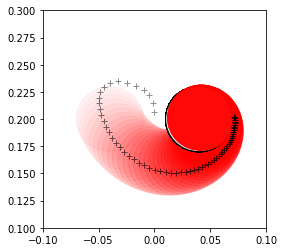

In [110]:
env_ddpg.reset()
env_ddpg.goal = np.array([0.04, 0.20])
env_ddpg.eef = np.array([0.00, 0.20])
env_ddpg.circle.pos = np.array([-0.04, 0.20])
fig, ax = plt.subplots(figsize=(4, 4))
for i in range(64):
    u = actor_target.u.predict(env_ddpg.get_state().reshape(1, 3)) / 100
    env_ddpg.step(u.flatten())
    ax.add_artist(plt.Circle(
        env_ddpg.goal,
        env_ddpg.circle.radius,
        color='k',
    ))
    ax.add_artist(plt.Circle(
        env_ddpg.goal,
        env_ddpg.circle.radius - 0.001,
        color='w',
    ))
    ax.add_artist(plt.Circle(
        deepcopy(env_ddpg.circle.pos),
        env_ddpg.circle.radius,
        alpha=(i / 64.0) ** 2,
        color='r',
    ))
    ax.plot(*env_ddpg.eef, '+', color='k', alpha=((53 + i) / (64 * 2.0)))
    ax.set_xlim((env_ddpg.min_x, env_ddpg.max_x))
    ax.set_ylim((env_ddpg.min_y, env_ddpg.max_y))
plt.savefig('ddpg-sim-pushing-series2.pdf')
plt.show()